In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing import image_dataset_from_directory


from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import cv2

import matplotlib.pyplot as plt

import os

In [2]:
TRAIN_DIR = 'Datasets/facial-recognition-dataset/Training/Training'
TEST_DIR = 'Datasets/facial-recognition-dataset/Testing/Testing'
BATCH_SIZE = 128
EPOCHS = 24

In [3]:
img = cv2.imread('Datasets/facial-recognition-dataset/Training/Training/Angry/Angry-1.jpg')
img.shape

(48, 48, 3)

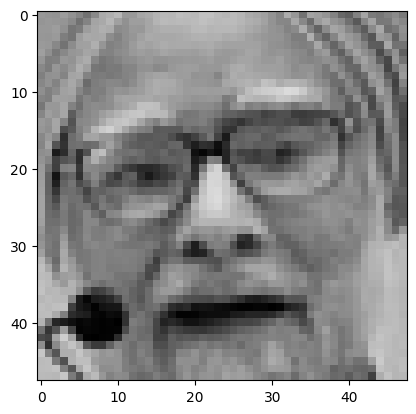

In [4]:
plt.imshow(img)

In [5]:
train_data = image_dataset_from_directory(
    TRAIN_DIR, 
    labels='inferred', 
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(48, 48)
    )
test_data = image_dataset_from_directory(
    TEST_DIR, 
    labels='inferred', 
    label_mode='categorical',
    batch_size=16,
    image_size=(48, 48)
    )

Found 28273 files belonging to 6 classes.
Found 7067 files belonging to 6 classes.


In [6]:
model = Sequential(
    [
        Conv2D(32, (3, 3), padding='same', activation="leaky_relu", input_shape=(48, 48, 3)),
        BatchNormalization(momentum=0.9),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding='same', activation="leaky_relu"),
        BatchNormalization(momentum=0.9),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', activation="leaky_relu"),
        BatchNormalization(momentum=0.9),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="leaky_relu"),
        Dropout(0.5),
        Dense(6, activation="softmax"),
    ]
)


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
class customCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85):
            print("\nAkurasi telah mencapai > 85%!")
            self.model.stop_training = True

callbacks = customCallback()

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00001)
# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [9]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,870 (2.61 MB)

 Trainable params: 684,422 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS,
    callbacks=[callbacks, reduce_lr, checkpoint]
)

Epoch 1/24
221/221 ━━━━━━━━━━━━━━━━━━━━ 133s 576ms/step - accuracy: 0.2696 - loss: 2.5878 - val_accuracy: 0.4187 - val_loss: 1.4830 - learning_rate: 0.0010
Epoch 2/24
221/221 ━━━━━━━━━━━━━━━━━━━━ 149s 671ms/step - accuracy: 0.4017 - loss: 1.5855 - val_accuracy: 0.4477 - val_loss: 1.4109 - learning_rate: 0.0010
Epoch 3/24
221/221 ━━━━━━━━━━━━━━━━━━━━ 119s 530ms/step - accuracy: 0.4796 - loss: 1.3544 - val_accuracy: 0.4950 - val_loss: 1.3074 - learning_rate: 0.0010
Epoch 4/24
221/221 ━━━━━━━━━━━━━━━━━━━━ 122s 546ms/step - accuracy: 0.5212 - loss: 1.2349 - val_accuracy: 0.5312 - val_loss: 1.2075 - learning_rate: 0.0010
Epoch 5/24
221/221 ━━━━━━━━━━━━━━━━━━━━ 117s 524ms/step - accuracy: 0.5573 - loss: 1.1547 - val_accuracy: 0.5312 - val_loss: 1.1965 - learning_rate: 0.0010
Epoch 6/24
221/221 ━━━━━━━━━━━━━━━━━━━━ 129s 578ms/step - accuracy: 0.5817 - loss: 1.1007 - val_accuracy: 0.5571 - val_loss: 1.1531 - learning_rate: 0.0010
Epoch 7/24
221/221 ━━━━━━━━━━━━━━━━━━━━ 157s 704ms/step - accura

In [11]:
model.evaluate(test_data)

442/442 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6028 - loss: 1.2053


[1.2132657766342163, 0.5982736945152283]

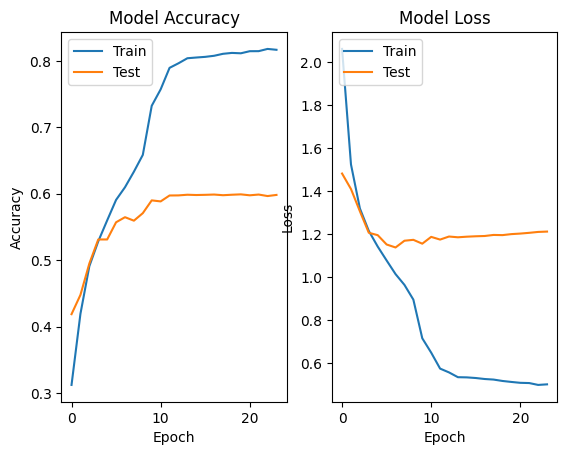

In [12]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [13]:
model.save("./model/model_adam_leaky_relu_1.h5")